#============================================================================================================================================
# **Física Teórica 3 (Mecánica Estadística): Teórica 6 - Extras**
#============================================================================================================================================

# Difusión en un gas de esferas rígidas en dos dimensiones
Las partículas del gas no interactúan entre sí excepto por choques elásticos. Cuando no interactúan, se desplazan en MRU. Tratamos los choques entre partículas intercambiando la velocidad de pares de partículas, cuando las partículas se acercan entre sí a una distancia menor a dos veces sus radios. En las paredes tenemos dos condiciones: (1) en la dirección x, asumimos que el dominio es periódico, y (2) en la dirección y tenemos paredes rígidas, las partículas se reflejan conservando la energía cinética. En este notebook comenzamos con las partículas concentradas en la región central con una distribución normal. El sistema se encuentra fuera del equilibrio, y evoluciona en el tiempo hacia un estado con densidad media uniforme. Mas tarde, comparamos los resultados contra los de una ecuación de difusión. Recordar que cada celda se debe ejecutar en orden, apretando SHIFT+ENTER:

Comenzamos definiendo diversos parámetros para el gas de partículas rígidas:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time as tm
from IPython import display

# Parámetros del sistema
N     = 500   # Número de partículas (>=2)
r     = .05   # Radio de las partículas
L     = 1     # Tamaño de la caja
m     = 1     # Masa de las partículas
E     = 1     # Energía cinética media total (inicial)
disp = .05*L  # Dispersión en la distribución inicial de partículas en x

# Parámetros para la simulación
step = 20     # Número total de pasos
jump = 1      # Número de pasos cada los cuales miramos la evolución
nbin = 10     # Número de bins en los histogramas

# Calculamos algunas cantidades necesarias para la simulación
sigma = np.sqrt(E/(N*m)) # Dispersión en la velocidad inicial de las partículas
dt    = r/sigma          # Paso temporal

# Creamos condiciones iniciales al azar. Las partículas están distribuidas espacialmente concentradas en el medio de la caja, con velocidad inicial distribuida en forma normal
x  = np.random.normal(.5*L,disp,N) # Partículas distribuidas en forma normal en el medio de la caja en x
y  = np.random.uniform(0+r,L-r,N)  # Partículas distribuidas uniformemente en y
vx = np.random.normal(0,sigma,N)
vy = np.random.normal(0,sigma,N)

# Creamos vectores y matrices para almacenar la evolución temporal
time = np.arange(int(step/jump))*dt*jump
dens = np.zeros((int(step/jump),nbin))

La siguiente celda realiza la simulación del gas de esferas rígidas:

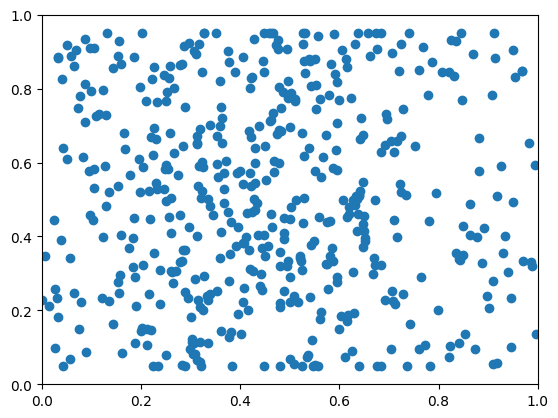

In [ ]:
fig = plt.figure()                                                   # Evolucionamos el sistema en el tiempo
tm.sleep(3)
for k in range(0,step):
	x = x + vx*dt                                                      # Evolucionamos la posición de las partículas según un MRU
	y = y + vy*dt
	# Tratamos los choques con las paredes: las partículas se reflejan en y, y pueden ganar o perder energía por agitación térmica de la pared
	crash = np.where(x<0)                                              # Pared de la derecha periódica
	x[crash]  = x[crash]+L
	crash = np.where(x>L)                                              # Pared de la izquierda periódica
	x[crash]  = x[crash]-L
	crash = np.where(y<0+r)                                            # Choques con la pared de abajo
	vy[crash] = -vy[crash]
	y[crash]  = 0+r
	crash = np.where(y>L-r)                                            # Choques con la pared de arriba
	vy[crash] = -vy[crash]
	y[crash]  = L-r
	for i in range(0,N):                                               # Tratamos los choques entre partículas: las partículas intercambian velocidades (conservación del momento y la energía)
		for j in range(0,N):
			if (x[i]-x[j])**2+(y[i]-y[j])**2 < (2*r)**2:
				tmp   = vx[i]
				vx[i] = vx[j]
				vx[j] = tmp
				tmp   = vy[i]
				vy[i] = vy[j]
				vy[j] = tmp
	if k % jump == 0:                                                  # Cada 'jump' pasos calculamos la densidad media en función de x, y graficamos la posición de las partículas
		tmp,bins = np.histogram(x, density=True, range=(0,L), bins=nbin) # Densidad lineal en función de x
		dens[int(k/jump),:] = tmp*N/(nbin*L)                             # Normalizamos el histograma para tener una "densidad" en los 10 bins
		plt.plot(x,y,'o')
		plt.xlim([0,L])
		plt.ylim([0,L])
		display.display(plt.gcf())
		display.clear_output(wait=True)
		plt.pause(0.01)

Graficamos la densidad lineal de partículas en función de x, para diferentes tiempos:

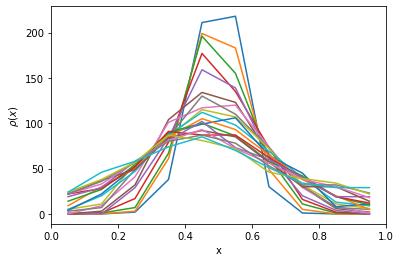

In [ ]:
plt.figure()
for i in range(0,int(step/jump)):
	plt.plot(bins[1:]-bins[1]/2,dens[i,:])
plt.xlabel(r'x')
plt.ylabel(r'$\rho(x)$')
plt.xlim(0,L)
plt.show()

Resolvamos ahora una ecuación para la densidad media en el mismo recinto, asumiendo que la difusión que observamos es similar a la que conocemos de la ecuación del calor (es decir, una ecuación de difusión). Usamos condiciones de contorno periódicas en x. Queremos resolver $$\frac{d\rho}{dt} = D \frac{d^2 \rho}{dx^2},$$ (donde D es un coeficiente efectivo de difusión, y en Phyton usamos r para $\rho$). Discretizamos esta ecuación usando diferencias finitas centradas, y obtenemos que en cada punto $i$ (en una malla de puntos entre 0 y $L$), $$\rho(i,t+dt) = \rho(i,t) + dt D \frac{\rho(i-1,t) + \rho(i+1,t) - 2 \rho(i,t)}{\Delta x^2}.$$

Comenzamos definiendo algunos parámetros para resolver la ecuación de difusión:

In [ ]:
# Parámetros del sistema
D  = .002 # Coeficiente de difusión

# Resolución espacial y paso temporal
dx = .02
dt = .5*dx**2/D

# Creamos un vector con la posición en los puntos x_i, y un vector para el tiempo con paso temporal dt
xi = np.arange(0,L,dx)
t  = np.arange(0,time[-1],dt)

# Creamos una condición inicial para la densidad lineal, dada por una Gaussiana centrada en el centro de la caja, y normalizada como la densidad lineal del gas de partículas
rho = np.mean(dens[-1,:])*np.exp(-.5*((xi-L/2)/disp)**2)/(disp*np.sqrt(2*np.pi))

Integramos la ecuación de difusión, y graficamos la solución cada 20 pasos temporales. El comando "np.roll" desplaza a todo el vector con la densidad una posición hacia la derecha o hacia la izquierda, haciendo fácil el cálculo de la derivada segunda por diferencias finitas: $$\frac{d^2 \rho}{dx^2} = \frac{\rho(i-1,t) + \rho(i+1,t) - 2 \rho(i,t)}{\Delta x^2}.$$

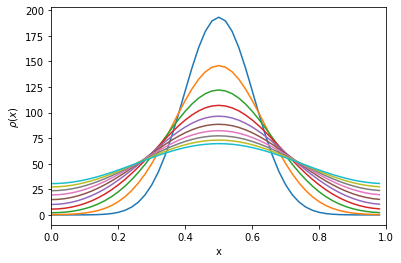

In [ ]:
plt.figure()
k = 0
for i in t:
	k = k+1
	rho = rho + dt*D* (np.roll(rho,-1) + np.roll(rho,1) - 2*rho)/dx**2
	if k % 20 == 0:
		plt.plot(xi,rho)
plt.xlabel(r'x')
plt.ylabel(r'$\rho(x)$')
plt.xlim(0,L)
plt.show()

#———————————————————————————————————————————————————————————————————————————————————————————————

#———————————————————————————————————————————————————————————————————————————————————————————————